In [64]:
import pandas as pd
import numpy as np
import re

def prepare_data_for_analysis(df):
    """
    Prepare dataset for performance analysis by extracting demographics and predictions.
    
    Args:
        df: DataFrame with columns ['Prompt', 'Metadata'] and model response columns
    Returns:
        DataFrame with demographics, binary predictions, unparsable flags, and empty flags
    """
    # Define model columns to analyze
    model_responses = [
        'chatgpt_response', 'claude_response', 'llama31_response',
        'llama32_response', 'phi_response', 'qwen_response', 
        'smol_response', 'rf_response', 'svm_response'
    ]
    
    # Extract demographics more robustly
    def extract_demographics(prompt):
        if not isinstance(prompt, str):
            return pd.Series({'gender': None, 'age': None, 'age_group': None})
            
        age_match = re.search(r'(\d+)-year-old', prompt)
        gender_match = re.search(r'-year-old\s+(\w+)', prompt)
        
        age = int(age_match.group(1)) if age_match else None
        gender = gender_match.group(1).lower() if gender_match else None
        
        # Convert gender to binary (1.0 for male, 0.0 for female)
        gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
        
        # Create age groups
        if age is not None:
            age_group = pd.cut([age], 
                             bins=[0, 30, 45, 60, float('inf')],
                             labels=['<30', '30-45', '45-60', '>60'])[0]
        else:
            age_group = None
            
        return pd.Series({'gender': gender_binary, 
                         'age': age, 
                         'age_group': age_group})
    
    # Extract demographics
    demographics = df['Prompt'].apply(extract_demographics)
    df = pd.concat([df, demographics], axis=1)
    
    # Create age group indicators
    for group in ['<30', '30-45', '45-60', '>60']:
        df[f'age_{group}'] = (df['age_group'] == group).astype(float)
    
    # Extract ground truth
    df['ground_truth'] = df['Metadata'].apply(
        lambda x: 1.0 if isinstance(x, str) and 'True' in x else 0.0
    )
    
    # Extract model predictions, unparsable flags, and empty flags
    for model_col in model_responses:
        model_name = model_col.split('_')[0]
        prediction_col = f'{model_name}_prediction'
        unparsable_col = f'{model_name}_unparsable'
        empty_col = f'{model_name}_empty'
        
        def analyze_response(x):
            # Check for empty or non-string responses
            if not isinstance(x, str):
                return pd.Series({
                    'prediction': 0.0,
                    'unparsable': 0.0,
                    'empty': 1.0
                })
            
            if not x.strip():  # Check if string is empty or only whitespace
                return pd.Series({
                    'prediction': 0.0,
                    'unparsable': 0.0,
                    'empty': 1.0
                })
            
            # Check for fraud/genuine conclusions
            has_fraud = 'CONCLUSION: FRAUD' in x.upper()
            has_genuine = 'CONCLUSION: GENUINE' in x.upper()
            
            return pd.Series({
                'prediction': 1.0 if has_fraud else 0.0,
                'unparsable': 0.0 if has_fraud or has_genuine else 1.0,
                'empty': 0.0
            })
        
        predictions = df[model_col].apply(analyze_response)
        df[prediction_col] = predictions['prediction']
        df[unparsable_col] = predictions['unparsable']
        df[empty_col] = predictions['empty']
    
    # Select relevant columns for analysis
    demographic_cols = ['gender', 'age', 'age_group'] + [f'age_{group}' for group in ['<30', '30-45', '45-60', '>60']]
    prediction_cols = [f"{model.split('_')[0]}_prediction" for model in model_responses]
    unparsable_cols = [f"{model.split('_')[0]}_unparsable" for model in model_responses]
    empty_cols = [f"{model.split('_')[0]}_empty" for model in model_responses]
    
    analysis_df = df[['ground_truth'] + demographic_cols + prediction_cols + unparsable_cols + empty_cols].copy()
    
    return analysis_df

# Usage example:
df = pd.read_csv('/home/hessel/code/master-thesis/src/results/final/final_dataset.ssv', sep=";")  # Load your data
analysis_df = prepare_data_for_analysis(df)

In [77]:
analysis_df.columns

Index(['ground_truth', 'gender', 'age', 'age_group', 'age_<30', 'age_30-45',
       'age_45-60', 'age_>60', 'chatgpt_prediction', 'claude_prediction',
       'llama31_prediction', 'llama32_prediction', 'phi_prediction',
       'qwen_prediction', 'smol_prediction', 'rf_prediction', 'svm_prediction',
       'chatgpt_unparsable', 'claude_unparsable', 'llama31_unparsable',
       'llama32_unparsable', 'phi_unparsable', 'qwen_unparsable',
       'smol_unparsable', 'rf_unparsable', 'svm_unparsable', 'chatgpt_empty',
       'claude_empty', 'llama31_empty', 'llama32_empty', 'phi_empty',
       'qwen_empty', 'smol_empty', 'rf_empty', 'svm_empty'],
      dtype='object')


Model Performance Metrics:
  model  tp   fp   tn  fn  total_samples  empty_responses  empty_rate  unparsable_responses  unparsable_rate  valid_responses  valid_rate  accuracy  precision  recall  f1_score  weighted_recall  weighted_f1  cost_sensitive_error
chatgpt   6  568 1102   5           1681              0.0      0.0000                   0.0           0.0000           1681.0      1.0000    0.6591     0.0105  0.5455    0.0205           0.3750       0.0203                0.3438
 claude   7  529 1137   4           1681              0.0      0.0000                   4.0           0.0024           1677.0      0.9976    0.6822     0.0131  0.6364    0.0256           0.4667       0.0254                0.3202
llama31   3  387  710   3           1681            116.0      0.0690                 462.0           0.2748           1103.0      0.6562    0.6464     0.0077  0.5000    0.0152           0.3333       0.0150                0.3563
llama32   4  288  634   2           1681              0.

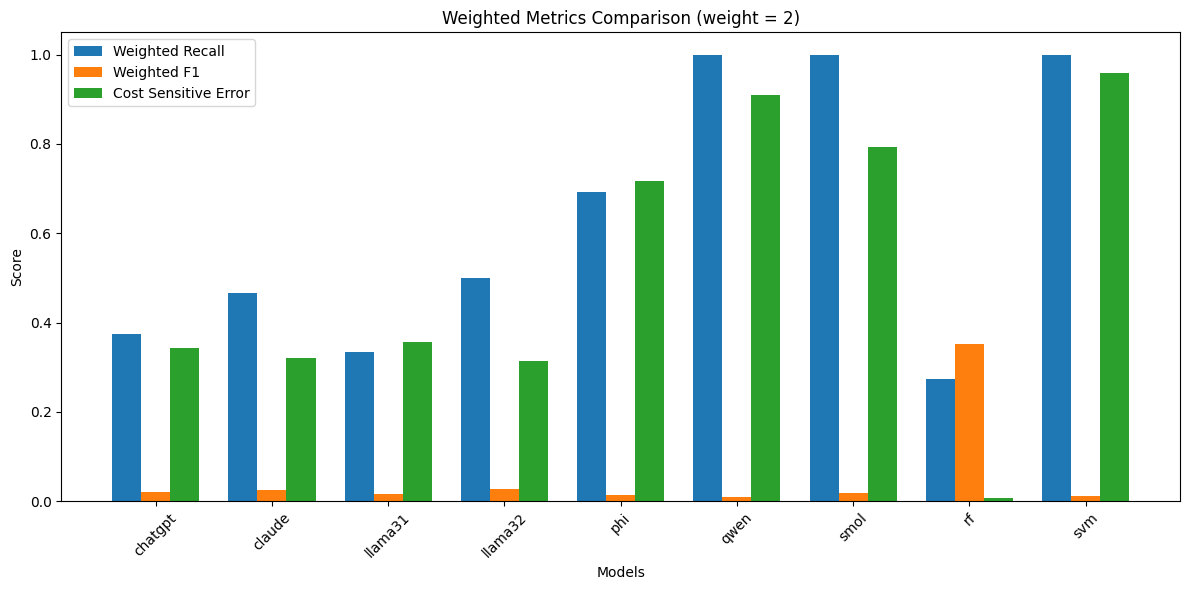

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_model_metrics(analysis_df, fraud_weight=10.0):
    """
    Analyze performance metrics for each model including weighted metrics for fraud detection.
    
    Args:
        analysis_df: DataFrame output from prepare_data_for_analysis()
        fraud_weight: Weight for fraud cases (cost of false negatives vs false positives)
    Returns:
        DataFrame with metrics per model
    """
    # Original code remains the same until metrics calculation
    model_names = [col.split('_')[0] for col in analysis_df.columns 
                  if col.endswith('_prediction')]
    
    metrics = []
    for model in model_names:
        prediction = f'{model}_prediction'
        unparsable = f'{model}_unparsable'
        empty = f'{model}_empty'
        
        total_samples = len(analysis_df)
        empty_count = analysis_df[empty].sum()
        unparsable_count = analysis_df[unparsable].sum()
        valid_count = total_samples - empty_count - unparsable_count
        
        valid_mask = (analysis_df[empty] == 0) & (analysis_df[unparsable] == 0)
        valid_df = analysis_df[valid_mask]
        
        if len(valid_df) > 0:
            tp = ((valid_df[prediction] == 1) & (valid_df['ground_truth'] == 1)).sum()
            fp = ((valid_df[prediction] == 1) & (valid_df['ground_truth'] == 0)).sum()
            tn = ((valid_df[prediction] == 0) & (valid_df['ground_truth'] == 0)).sum()
            fn = ((valid_df[prediction] == 0) & (valid_df['ground_truth'] == 1)).sum()
            
            # Standard metrics
            accuracy = (tp + tn) / len(valid_df) if len(valid_df) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            # Weighted metrics
            weighted_fn = fn * fraud_weight
            weighted_recall = tp / (tp + weighted_fn) if (tp + weighted_fn) > 0 else 0
            weighted_f1 = 2 * (precision * weighted_recall) / (precision + weighted_recall) if (precision + weighted_recall) > 0 else 0
            
            # Cost-sensitive error metric (lower is better)
            cost_sensitive_error = (fp + fraud_weight * fn) / len(valid_df)
        else:
            accuracy = precision = recall = f1 = weighted_recall = weighted_f1 = 0
            cost_sensitive_error = float('inf')
        
        metrics.append({
            'model': model,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
            'total_samples': total_samples,
            'empty_responses': empty_count,
            'empty_rate': empty_count / total_samples,
            'unparsable_responses': unparsable_count,
            'unparsable_rate': unparsable_count / total_samples,
            'valid_responses': valid_count,
            'valid_rate': valid_count / total_samples,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'weighted_recall': weighted_recall,
            'weighted_f1': weighted_f1,
            'cost_sensitive_error': cost_sensitive_error
        })
    
    metrics_df = pd.DataFrame(metrics)
    numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
    metrics_df[numeric_cols] = metrics_df[numeric_cols].round(4)
    
    return metrics_df

def plot_weighted_metrics(metrics_df, fraud_weight):
    """
    Create a grouped bar plot comparing weighted metrics across models.
    
    Args:
        metrics_df: DataFrame output from analyze_model_metrics()
        title: Plot title
    """

    title=f"Weighted Metrics Comparison (weight = {fraud_weight})"

    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    metrics_to_plot = ['weighted_recall', 'weighted_f1', 'cost_sensitive_error']
    x = np.arange(len(metrics_df['model']))
    width = 0.25
    
    # Create grouped bars
    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + i*width, 
               metrics_df[metric], 
               width, 
               label=metric.replace('_', ' ').title())
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x + width, metrics_df['model'], rotation=45)
    plt.legend()
    
    plt.tight_layout()
    return plt
fraud_weight = 2
# Usage example:
metrics_df = analyze_model_metrics(analysis_df,fraud_weight)

# Print overall metrics
print(f"\nModel Performance Metrics:")
print(metrics_df.to_string(index=False))

# Create and show the plot
plot = plot_weighted_metrics(metrics_df, fraud_weight)
plt.show()

In [66]:
def filter_traditional_ml_responses(analysis_df):
    """
    Filter dataset to only include rows where RF and SVM provided non-empty responses.
    
    Args:
        analysis_df: DataFrame output from prepare_data_for_analysis()
    Returns:
        DataFrame with only rows where RF and SVM provided non-empty responses
    """
    # Create mask for non-empty RF and SVM responses
    rf_svm_empty_mask = (analysis_df['rf_empty'] == 0) & (analysis_df['svm_empty'] == 0)
    
    # Filter dataset
    filtered_df = analysis_df[rf_svm_empty_mask].copy()
    
    # Print statistics
    print(f"Original dataset size: {len(analysis_df)}")
    print(f"Filtered dataset size: {len(filtered_df)}")
    print(f"Removed {len(analysis_df) - len(filtered_df)} rows ({((len(analysis_df) - len(filtered_df)) / len(analysis_df) * 100):.2f}%) with empty RF or SVM responses")
    
    # Additional statistics about other models in the filtered set
    other_models = [col.split('_')[0] for col in analysis_df.columns 
                   if col.endswith('_empty') and col not in ['rf_empty', 'svm_empty']]
    
    print("\nEmpty response rates in filtered dataset:")
    for model in other_models:
        empty_count = filtered_df[f'{model}_empty'].sum()
        empty_rate = (empty_count / len(filtered_df)) * 100
        print(f"{model}: {empty_count} empty responses ({empty_rate:.2f}%)")
    
    return filtered_df

# Usage example:
filtered_analysis_df = filter_traditional_ml_responses(analysis_df)

# Recalculate metrics on filtered dataset
filtered_metrics_df = analyze_model_metrics(filtered_analysis_df)

# Print new metrics
print("\nModel Performance Metrics (RF and SVM non-empty responses only):")
print(filtered_metrics_df.to_string(index=False))

Original dataset size: 1681
Filtered dataset size: 1380
Removed 301 rows (17.91%) with empty RF or SVM responses

Empty response rates in filtered dataset:
chatgpt: 0.0 empty responses (0.00%)
claude: 0.0 empty responses (0.00%)
llama31: 4.0 empty responses (0.29%)
llama32: 0.0 empty responses (0.00%)
phi: 0.0 empty responses (0.00%)
qwen: 5.0 empty responses (0.36%)
smol: 568.0 empty responses (41.16%)

Model Performance Metrics (RF and SVM non-empty responses only):
  model  tp   fp   tn  fn  total_samples  empty_responses  empty_rate  unparsable_responses  unparsable_rate  valid_responses  valid_rate  accuracy  precision  recall  f1_score
chatgpt   3  468  905   4           1380              0.0      0.0000                   0.0           0.0000           1380.0      1.0000    0.6580     0.0064  0.4286    0.0126
 claude   5  442  928   2           1380              0.0      0.0000                   3.0           0.0022           1377.0      0.9978    0.6776     0.0112  0.7143    0.0

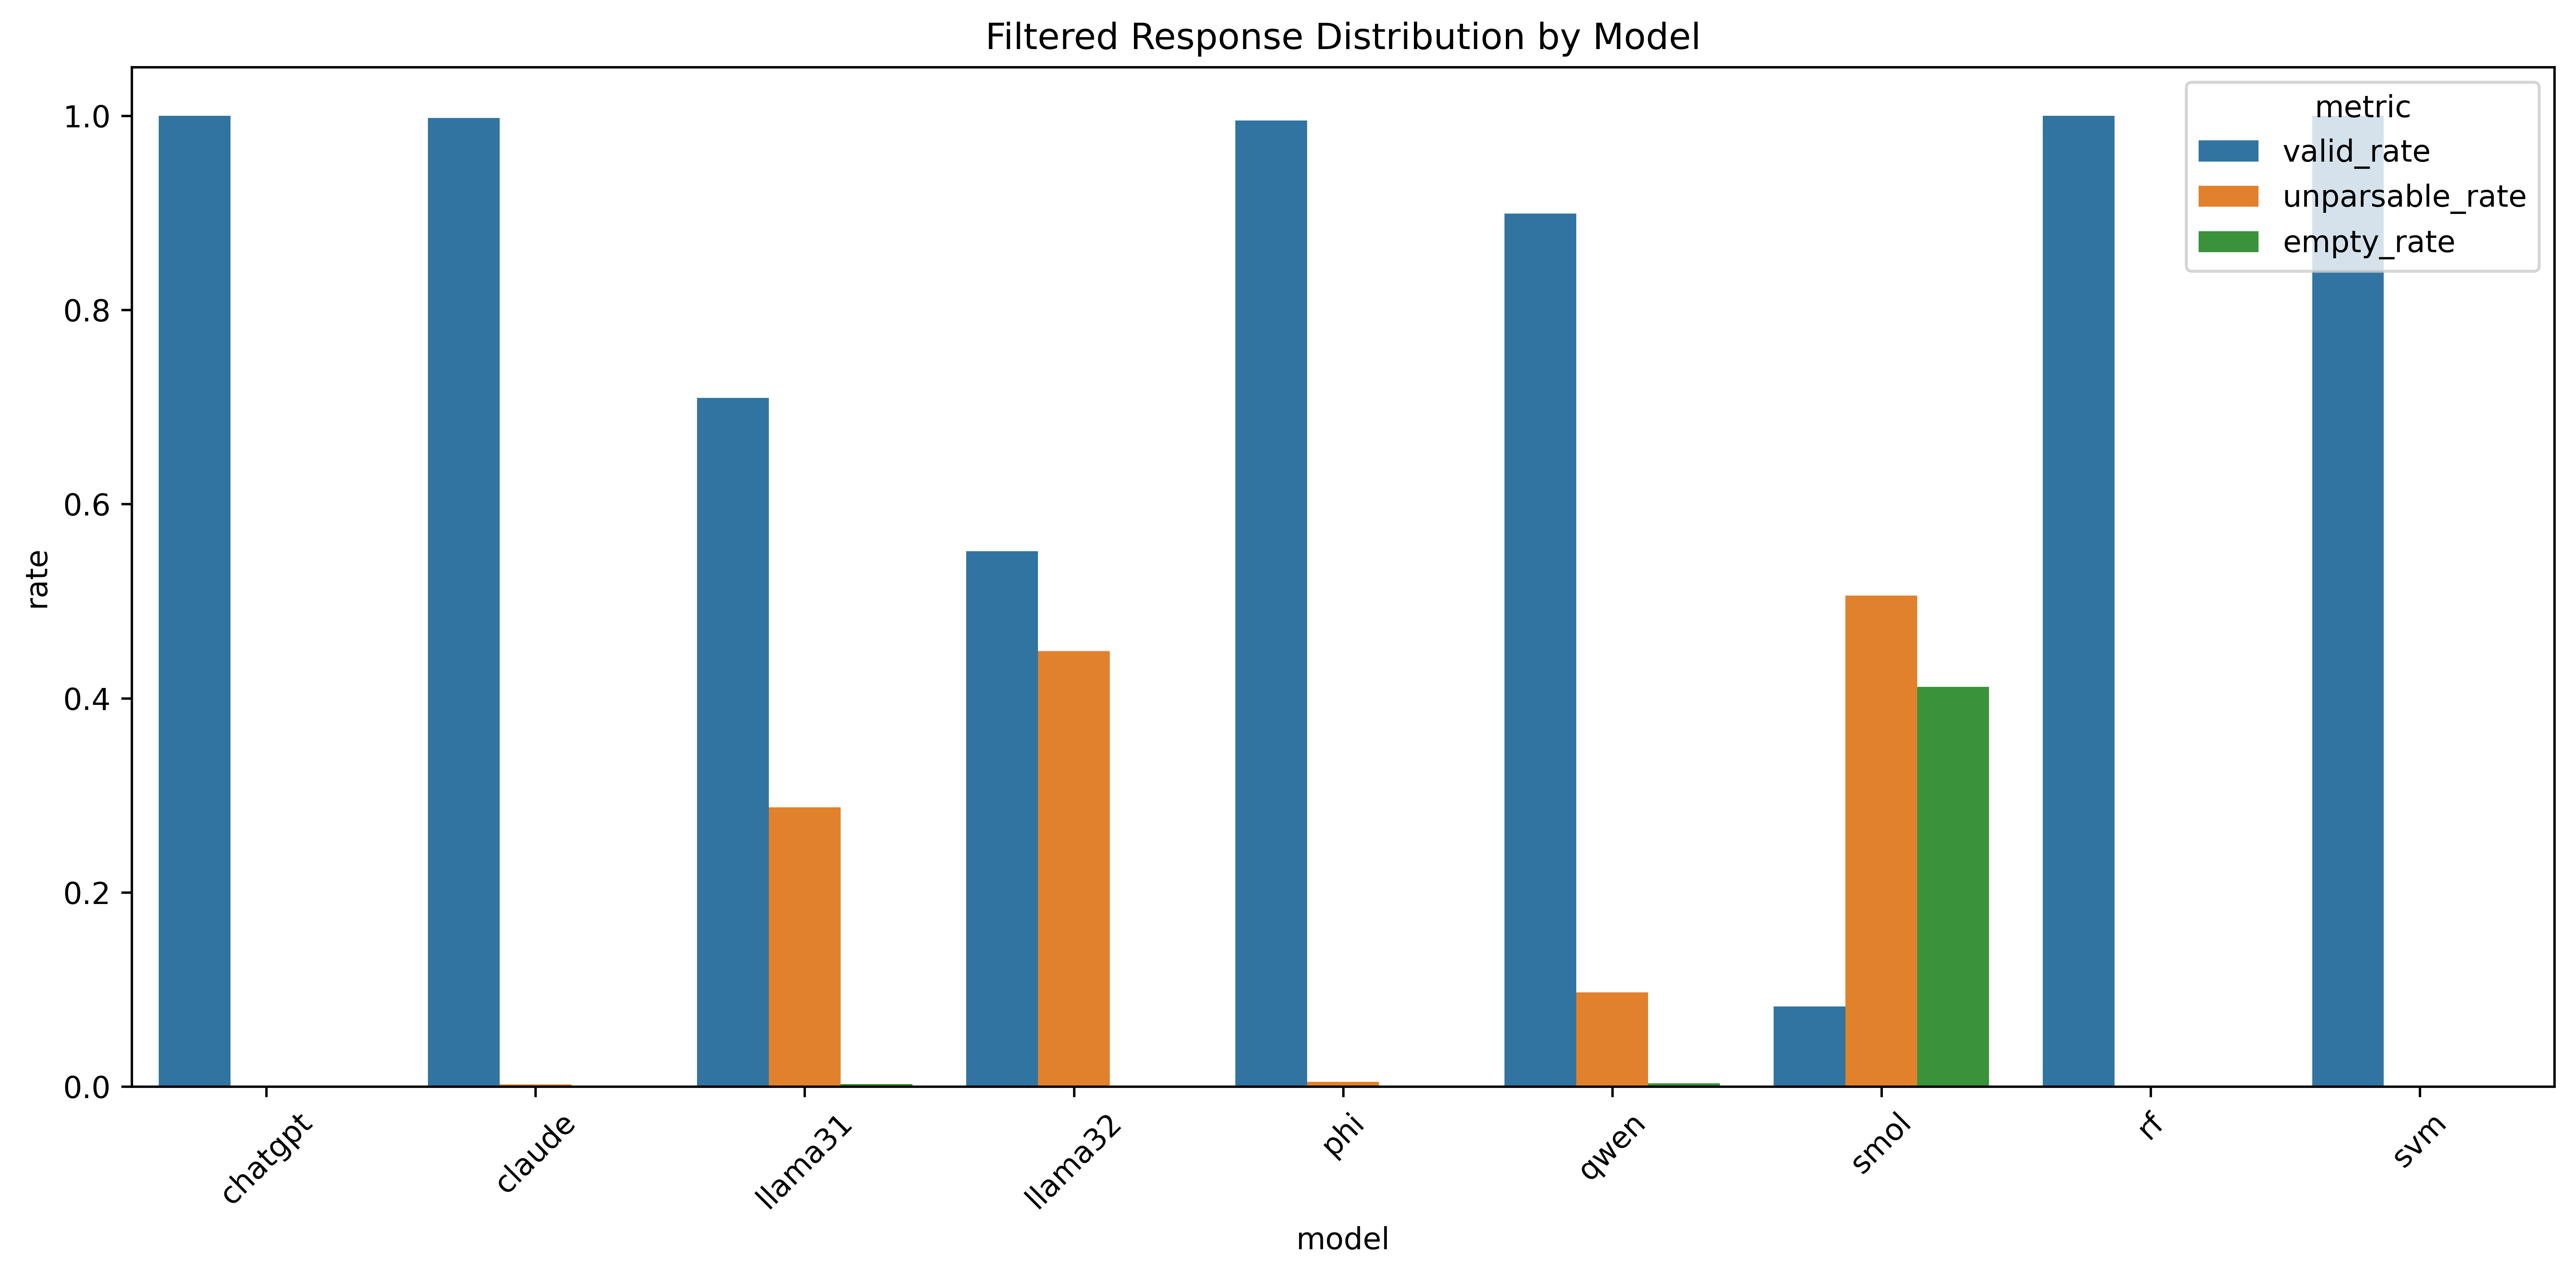

      model     metric   score
0   chatgpt   accuracy  0.6580
1    claude   accuracy  0.6776
2   llama31   accuracy  0.6466
3   llama32   accuracy  0.6925
4       phi   accuracy  0.2768
5      qwen   accuracy  0.0894
6      smol   accuracy  0.2193
7        rf   accuracy  0.9949
8       svm   accuracy  0.0406
9   chatgpt  precision  0.0064
10   claude  precision  0.0112
11  llama31  precision  0.0087
12  llama32  precision  0.0128
13      phi  precision  0.0060
14     qwen  precision  0.0053
15     smol  precision  0.0111
16       rf  precision  0.5000
17      svm  precision  0.0053
18  chatgpt     recall  0.4286
19   claude     recall  0.7143
20  llama31     recall  0.5000
21  llama32     recall  0.6000
22      phi     recall  0.8571
23     qwen     recall  1.0000
24     smol     recall  1.0000
25       rf     recall  0.4286
26      svm     recall  1.0000
27  chatgpt   f1_score  0.0126
28   claude   f1_score  0.0220
29  llama31   f1_score  0.0170
30  llama32   f1_score  0.0250
31      

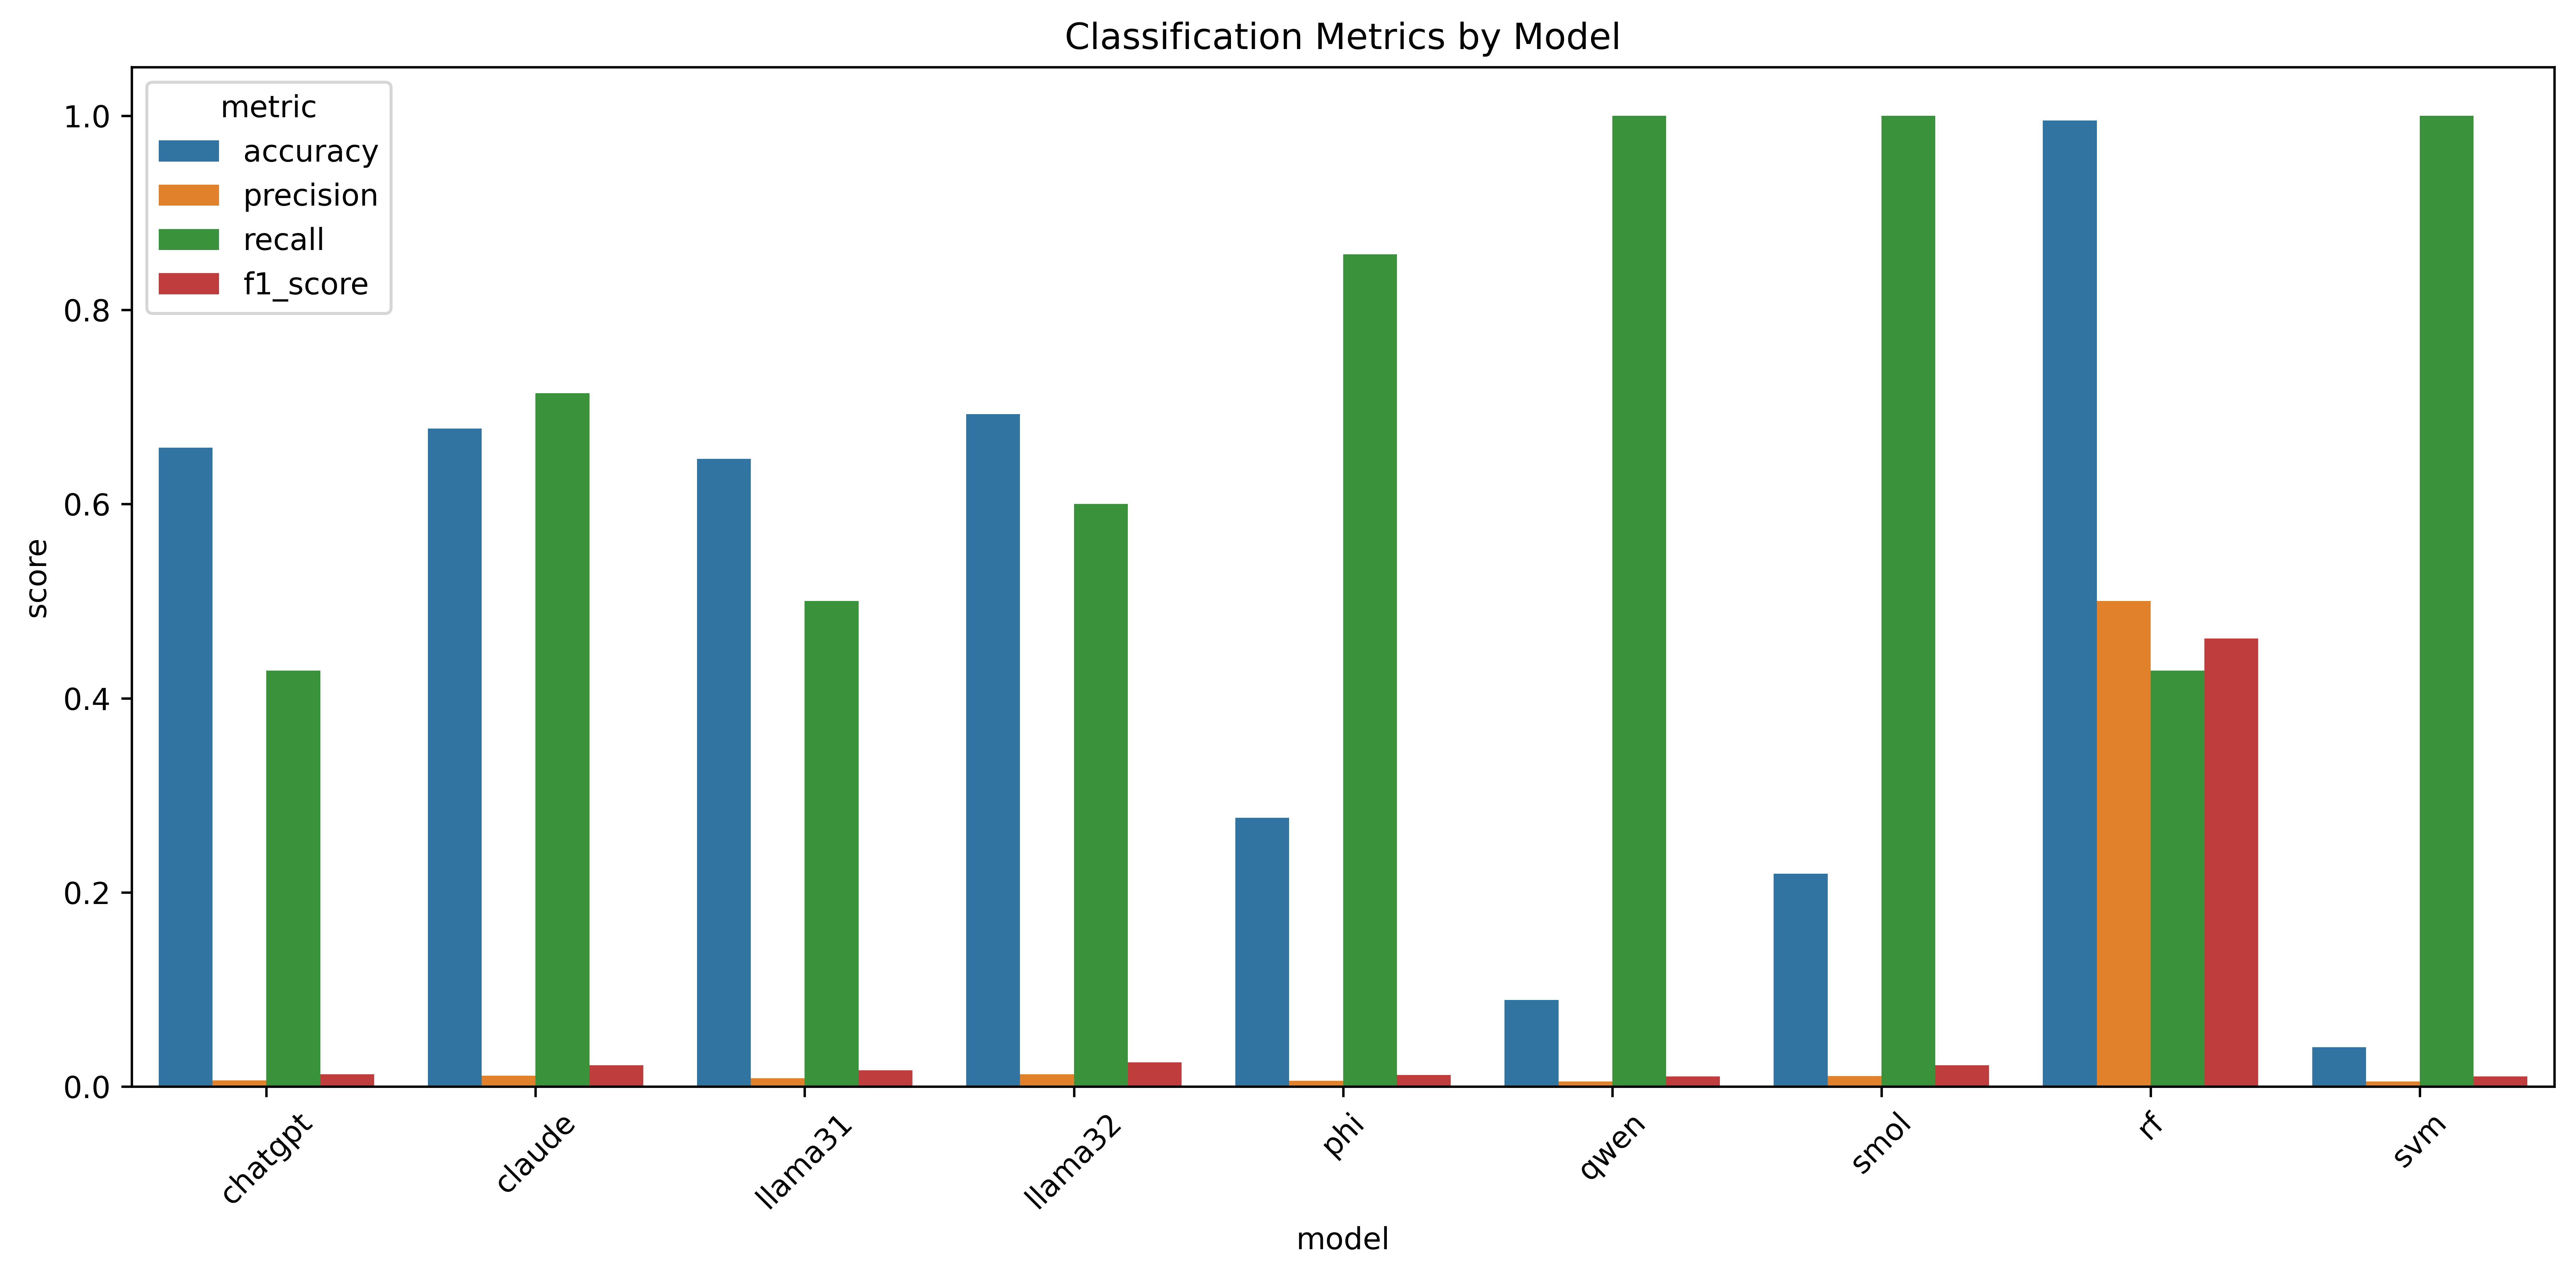

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import auc

# Original plots
def plot_response_quality(filtered_metrics_df):
    response_quality = filtered_metrics_df[['model', 'valid_rate', 'unparsable_rate', 'empty_rate']]
    response_quality_melted = response_quality.melt(
        id_vars=['model'], 
        var_name='metric', 
        value_name='rate'
    )

    plt.figure(figsize=(12, 6), dpi=600)
    sns.barplot(data=response_quality_melted, x='model', y='rate', hue='metric')
    plt.title('Filtered Response Distribution by Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_classification_metrics(filtered_metrics_df):
    classification_metrics = filtered_metrics_df[['model', 'accuracy', 'precision', 'recall', 'f1_score']]
    classification_melted = classification_metrics.melt(
        id_vars=['model'], 
        var_name='metric', 
        value_name='score'
    )
    print(classification_melted)

    plt.figure(figsize=(12, 6), dpi=600)
    sns.barplot(data=classification_melted, x='model', y='score', hue='metric')
    plt.title('Classification Metrics by Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Plot all metrics
plot_response_quality(filtered_metrics_df)
plot_classification_metrics(filtered_metrics_df)


In [48]:
def filter_non_empty_responses(analysis_df):
    """
    Filter dataset to only include rows where no model has an empty response.
    
    Args:
        analysis_df: DataFrame output from prepare_data_for_analysis()
    Returns:
        DataFrame with only rows where all models provided non-empty responses
    """
    # Get all empty flag columns
    empty_cols = [col for col in analysis_df.columns if col.endswith('_empty')]
    
    # Create mask where sum of empty flags is 0 (no empty responses)
    non_empty_mask = analysis_df[empty_cols].sum(axis=1) == 0
    
    # Filter dataset
    filtered_df = analysis_df[non_empty_mask].copy()
    
    # Print statistics
    print(f"Original dataset size: {len(analysis_df)}")
    print(f"Filtered dataset size: {len(filtered_df)}")
    print(f"Removed {len(analysis_df) - len(filtered_df)} rows ({((len(analysis_df) - len(filtered_df)) / len(analysis_df) * 100):.2f}%) with empty responses")
    
    return filtered_df

# Usage example:
filtered_analysis_df = filter_non_empty_responses(analysis_df)

Original dataset size: 1681
Filtered dataset size: 807
Removed 874 rows (51.99%) with empty responses


In [84]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

def calculate_fraud_metrics(y_true, y_pred):
    """Calculate fraud detection specific metrics"""
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        fnr = fn / (fn + tp)  # False Negative Rate
        
        return {
            'recall': round(recall, 4),
            'precision': round(precision, 4),
            'f1': round(f1, 4),
            'fnr': round(fnr, 4),
            'false_negatives': fn,
            'true_positives': tp
        }
    except:
        return {
            'recall': 0,
            'precision': 0,
            'f1': 0,
            'fnr': 1,
            'false_negatives': 0,
            'true_positives': 0
        }

def run_metrics_comparison(data, prediction_columns):
    """Compare fraud detection metrics across models"""
    metrics = {}
    for model in prediction_columns:
        metrics[model] = calculate_fraud_metrics(
            data['ground_truth'], 
            data[model]
        )
    
    return pd.DataFrame(metrics).T

# Define model groups
llm_models = ['chatgpt_prediction', 'claude_prediction', 'llama31_prediction', 
              'llama32_prediction', 'phi_prediction', 'qwen_prediction', 'smol_prediction']
conventional_models = ['rf_prediction', 'svm_prediction']
all_models = llm_models + conventional_models

# Calculate metrics for all models
print("Individual Model Metrics:")
model_metrics = run_metrics_comparison(filtered_analysis_df, all_models)
print(model_metrics)

# Calculate average metrics for each class
def calculate_class_metrics(data, models):
    all_true = []
    all_pred = []
    for model in models:
        all_true.extend(data['ground_truth'])
        all_pred.extend(data[model])
    return calculate_fraud_metrics(np.array(all_true), np.array(all_pred))

print("\nModel Class Metrics:")
llm_metrics = calculate_class_metrics(filtered_analysis_df, llm_models)
conv_metrics = calculate_class_metrics(filtered_analysis_df, conventional_models)

class_metrics = pd.DataFrame({
    'LLM Models': llm_metrics,
    'Conventional Models': conv_metrics
}).T

print(class_metrics)

# Run ANOVA on recall scores (since false negatives are most important)
def get_recall_values(data, models):
    recalls = []
    for model in models:
        true_pos = (data['ground_truth'] & data[model]).sum()
        actual_pos = data['ground_truth'].sum()
        recalls.extend([true_pos/actual_pos] * len(data))
    return recalls

llm_recalls = get_recall_values(filtered_analysis_df, llm_models)
conv_recalls = get_recall_values(filtered_analysis_df, conventional_models)

f_stat, p_value = stats.f_oneway(np.array(llm_recalls), np.array(conv_recalls))

print("\nRecall-based ANOVA Results:")
print(f"F-statistic: {round(f_stat, 4)}")
print(f"p-value: {round(p_value, 4)}")

# Calculate effect size for recall comparison
def calculate_eta_squared(f_stat, groups, total_n):
    return (f_stat * (groups - 1)) / (f_stat * (groups - 1) + (total_n - groups))

total_n = len(llm_recalls) + len(conv_recalls)
recall_eta_squared = calculate_eta_squared(f_stat, 2, total_n)

print("\nEffect Size (η²) for Recall Comparison:")
print(f"Model Classes: {recall_eta_squared:.4f}")

# Additional analysis: Find models with lowest false negative rates
print("\nModels Ranked by False Negative Rate (lower is better):")
fnr_ranking = model_metrics.sort_values('fnr')['fnr']
print(fnr_ranking)

Individual Model Metrics:
                    recall  precision      f1     fnr  false_negatives  \
chatgpt_prediction  0.4286     0.0064  0.0126  0.5714              4.0   
claude_prediction   0.7143     0.0112  0.0220  0.2857              2.0   
llama31_prediction  0.4286     0.0087  0.0170  0.5714              4.0   
llama32_prediction  0.4286     0.0128  0.0248  0.5714              4.0   
phi_prediction      0.8571     0.0060  0.0119  0.1429              1.0   
qwen_prediction     0.8571     0.0053  0.0105  0.1429              1.0   
smol_prediction     0.1429     0.0111  0.0206  0.8571              6.0   
rf_prediction       0.4286     0.5000  0.4615  0.5714              4.0   
svm_prediction      1.0000     0.0053  0.0105  0.0000              0.0   

                    true_positives  
chatgpt_prediction             3.0  
claude_prediction              5.0  
llama31_prediction             3.0  
llama32_prediction             3.0  
phi_prediction                 6.0  
qwen_predic

TypeError: unsupported operand type(s) for &: 'float' and 'float'